# PRÁCTICA MACHINE LEARNING KEEPCODING 2020

### Importamos todas lasl librerías que vayamos a utilizar en el proyecto

In [1]:
import warnings
import pandas as pd #To work with dataframes
import numpy as np #To operate with the data.
import sklearn #To use lineal regresion models.
import operator #To sort a dictionary.
from sklearn.feature_selection import f_regression, mutual_info_regression

In [2]:
import matplotlib.pyplot as plt # para dibujar

%matplotlib inline
from matplotlib import cm

plt.rcParams['figure.figsize'] = (16, 16)
plt.style.use('ggplot')

warnings.simplefilter('ignore')

### Leemos el dataset que tenemos en formato .csv y lo convertimos en un dataframe

In [3]:
#Pandas nos mostrará todas los columnas y filas sin sesgar la información.
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
#Leemos el csv de airbnb y lo convertimos en un dataframe.
df = pd.read_csv("airbnb-listings-extract.csv", sep=";")

Voy a filtrar el campo de "City" por Madrid, ya que no tiene sentido comparar viviendas que sean de distintas ciudades o incluso de distintos países. Ya que el precio de la vivienda varia mucho dependiendo de la ciudad. 

#### Se podría filtrar por país directamente o por cualquier otra ciudad.

In [5]:
# Me quedo unicamente con las viviendas de Madrid.
df = df[df["City"] == "Madrid"]

In [6]:
#Cambio el nombre de las columnas sustituyendo los espacios en blanco por barras bajas para poder trabajar mejor
# a posteriori con el dataframe
new_columns = [str(column).replace(" ","_") for column in df.columns]
df.columns = new_columns

### Creación del dataframe de train y el dataframe de test.

In [7]:
#Calculo el número de filas que tengo en mi dataframe
nrows = df.shape[0]

In [8]:
# Calculo el número de filas que voy a meter en el train y el número que voy a meter en test.
# En este caso utilizo un 75% del dataframe original para crear el dataset de train y el 25% para el dataset de test.

nrows_train = int(round(nrows*0.75,0))
nrows_test = int(nrows_train + 1)

In [9]:
# Creo un dataframe para train y otro para test.
df_train = df.iloc[:nrows_train, :]
df_test = df.iloc[nrows_test:, :]

In [10]:
print(df_train.shape)
print(df_test.shape)

(9905, 89)
(3301, 89)


## A partir de aquí trabajo con el dataframe de train

### Selección de las columnas más relevantes.

In [11]:
# La función select_columns recibe como parámetro el dataframe con el que estamos trabajando.
# Me quedo con las columnas más útiles.
# Por útiles entiendo parámetros que tienen en común todas las viviendas, es decir, número de habitaciones, número de reviews
# código postal. Es decir, datos concretos.

# Elimino todos aquellos datos que son abstractos como fechas, url's, Ids de varios tipos, opiniones, descripciones...

# Aquí basta con añadir una columna a la lista "useful_columns" para incluirla en el dataframe. Se puede cambiar en cualquier 
# momento y añadir o quitar las columnas que se quiera y ejectutar el código de nuevo.
def select_columns(dataframe):
    
    useful_columns =  ["Neighbourhood","Zipcode","Property_Type",
                        "Room_Type", "Accommodates", "Bathrooms", "Bedrooms",
                        "Beds", "Bed_Type", "Price","Number_of_Reviews",
                        "Review_Scores_Value","Cancellation_Policy",
                        "Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit",
                        "Cleaning_Fee"]

    dataframe = dataframe[useful_columns]
    
    return dataframe

In [12]:
#Analizo los valores de Zipcode, ya que he visto que hay varios que vienen por defecto con errores.

# Por ello, mediante un replace, solvento todos los errores que he visto al hacer un df_train["Zipcode"].unique()

def clean_zipcode(dataframe):
    
    dataframe["Zipcode"].replace({"28002\n28002": "28002",
                                 "Madrid 28004": "28004",
                                 "2805":"28005",
                                 "2015":"28015",
                                 "2815":"28015",
                                 "2804":"28004",
                                 "28850":"28050",
                                 "280013":"28013",
                                 "20013":"28013"}, inplace=True)  
    
    #Convierto el campo "Zipcode" en un campo de tipo numérico para incluirlo en la matriz de correlación.
    dataframe = dataframe[dataframe['Zipcode'].notna()]
    dataframe["Zipcode"] = dataframe["Zipcode"].apply(pd.to_numeric, errors='coerce')
    
    return dataframe

### Creación de la función "column_encode" para codificar todas aquellas columnas que sean necesarias codificar.

In [13]:
# Función que codifica la columna que le indiquemos dentro de un dataframe:
# Tiene como parámetros el dataframe con el que estamos trabajando y el nombre de la columna que queremos codificar.
# Devuelve el dataframe con la columna original y justo a su derecha, la columna codificada nueva.
# Este modelo tiene de ventajas que podemos incluir o excluir una columna en cualquier momento sin problemas.

def column_encode(dataframe, df_column):

    column_values = dataframe[df_column].unique() 

    dictionary = {}
    counter = 0
    
    columns = list(dataframe.columns)
    
    new_column = f"{df_column}_Code"

    for value in column_values:
        if value not in dictionary.keys():
            if str(value) == "NaN" or str(value) == "Nan" or str(value) == "nan":
                dictionary[value] = value
            else:
                dictionary[value] = counter
                counter =+ counter +1

    df_add = pd.DataFrame({df_column: list(dictionary.keys()),
                                     new_column: list(dictionary.values()) 
                                    })

    dataframe = pd.merge(dataframe, df_add, on= df_column)
    
    for ix, column in enumerate(columns):
        if str(column) == str(df_column):
            columns.insert(ix + 1, new_column)        
    
    dataframe = dataframe[columns]
    
    return dataframe  

### Función "delete_object_column". Limpieza del dataframe

In [14]:
# Función delete object_columns. Recibe como parámetro el dataframe con el que estamos trabajando.
# Me quedo únicamente con los campos numéricos y los campos codificados.

def delete_object_columns(dataframe):
    
    df_object_columns = dataframe.dtypes.apply(lambda x: x.name).to_dict()
    
    for column in list(df_object_columns.keys()):
        if str(df_object_columns[column]) == 'object':
            dataframe = dataframe.drop(columns = [column])
    
    return dataframe

In [15]:
# La función convert to numeric convierte todos los campos del dataframe a int64.
# Esto lo hago porque pueden saltar errores al ser datos numéricos muy largos de tipo "float".

def convert_to_numeric(dataframe):
    
    dataframe = dataframe.apply(pd.to_numeric, errors='coerce')
    
    return dataframe

### Función "main_encode". Implementa la función de "column_encode".

In [16]:
# La función main_encode recibe como parámetro el dataframe con el que estamos trabajando e implementa todo los métodos anteriores a la vez.

# En esta función, cuando empleamos el método column_encode,tenemos que indicar aquellas columnas que queramos codificar.

# Se pueden añadir o quitar campos en cualquier momento que se quiera hacer cambios, pero hay que tener en cuenta que las 
# columnas que incluyamos tienen que estar en el dataframe.

def main_process_data_train(dataframe):
    
    df_processed = select_columns(dataframe)
    
    df_processed = clean_zipcode(df_processed)
    
    df_processed = column_encode(df_processed,"Neighbourhood")
    df_processed = column_encode(df_processed,"Property_Type")
    df_processed = column_encode(df_processed,"Room_Type")
    df_processed = column_encode(df_processed,"Bed_Type")
    df_processed = column_encode(df_processed,"Cancellation_Policy")
    
        
    return df_processed

In [17]:
# Ahora llamamos a la función "main_encode" y codificamos todas aquellas columnas que hayamos seleccionado:
df_train = main_process_data_train(df_train)

### Función "delete_object_column". Limpieza del dataframe

In [18]:
df_type = df_train.dtypes.apply(lambda x: x.name).to_dict()
df_type

{'Neighbourhood': 'object',
 'Neighbourhood_Code': 'float64',
 'Zipcode': 'int64',
 'Property_Type': 'object',
 'Property_Type_Code': 'int64',
 'Room_Type': 'object',
 'Room_Type_Code': 'int64',
 'Accommodates': 'int64',
 'Bathrooms': 'float64',
 'Bedrooms': 'float64',
 'Beds': 'float64',
 'Bed_Type': 'object',
 'Bed_Type_Code': 'int64',
 'Price': 'float64',
 'Number_of_Reviews': 'int64',
 'Review_Scores_Value': 'float64',
 'Cancellation_Policy': 'object',
 'Cancellation_Policy_Code': 'int64',
 'Square_Feet': 'float64',
 'Weekly_Price': 'float64',
 'Monthly_Price': 'float64',
 'Security_Deposit': 'float64',
 'Cleaning_Fee': 'float64'}

### Información del dataset

In [19]:
# Obetenemos información del dataframe.
# En la columna count, ya se aprecia que hay columnas que tienen valores nulos, los cuales tenemos que eliminar para dejar 
# el dataset lo más limpio posible.
df_info = df_train.describe().T
df_info

,count,mean,std,min,25%,50%,75%,max
Neighbourhood_Code,6541.0,37.764256,16.939768,0.0,27.0,41.0,53.0,64.0
Zipcode,9576.0,28014.448204,34.697617,25008.0,28005.0,28012.0,28015.0,28105.0
Property_Type_Code,9576.0,0.544277,1.719349,0.0,0.0,0.0,0.0,21.0
Room_Type_Code,9576.0,0.636905,0.509186,0.0,0.0,1.0,1.0,2.0
Accommodates,9576.0,3.212824,2.006524,1.0,2.0,3.0,4.0,16.0
Bathrooms,9545.0,1.254531,0.596104,0.0,1.0,1.0,1.0,8.0
Bedrooms,9568.0,1.297032,0.835343,0.0,1.0,1.0,2.0,10.0
Beds,9554.0,1.986393,1.510500,1.0,1.0,2.0,2.0,16.0
Bed_Type_Code,9576.0,0.041667,0.291279,0.0,0.0,0.0,0.0,4.0
Price,9573.0,66.744699,57.021687,9.0,32.0,54.0,80.0,875.0


<!-- ### Análisis de los datos sobre el dataframe original. -->

### Análisis del dataframe de train.

#### Cálculo de la cantidad de valores nulos que contienen cada columna.

In [20]:
#Saco el número de filas utilizando la función shape.
max_value = df_train.shape[0]

In [21]:
#Añado dos campos nuevos al df_info. 
# En campo null_values, indico cuantos valores nulos tiene cada campo.
# En campo null_values_percent, indico porcentaje representan los valores nulos en ese campo.
df_info["null_values"] = max_value - df_info["count"]
df_info["null_values_percent"] = round((df_info["null_values"]/max_value)*100,2)

In [22]:
#Ordeno el df_info por la columna de "null_values"
df_info.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,381.0,375.451444,565.597593,0.0,0.0,86.0,624.0,5167.0,9195.0,96.02
Monthly_Price,2453.0,1347.252752,895.841457,250.0,700.0,1200.0,1690.0,8820.0,7123.0,74.38
Weekly_Price,2496.0,372.493189,191.290445,70.0,210.0,350.0,495.0,999.0,7080.0,73.93
Security_Deposit,4129.0,184.137079,109.619376,70.0,100.0,150.0,200.0,990.0,5447.0,56.88
Cleaning_Fee,5764.0,29.768043,26.487805,4.0,15.0,25.0,35.0,500.0,3812.0,39.81
Neighbourhood_Code,6541.0,37.764256,16.939768,0.0,27.0,41.0,53.0,64.0,3035.0,31.69
Review_Scores_Value,7523.0,9.208693,0.945072,2.0,9.0,9.0,10.0,10.0,2053.0,21.44
Bathrooms,9545.0,1.254531,0.596104,0.0,1.0,1.0,1.0,8.0,31.0,0.32
Beds,9554.0,1.986393,1.510500,1.0,1.0,2.0,2.0,16.0,22.0,0.23
Bedrooms,9568.0,1.297032,0.835343,0.0,1.0,1.0,2.0,10.0,8.0,0.08


### Elimino las columnas que poseen más de un 25% de valores nulos.

In [23]:
# Aquí compruebo cuales son las columnas que tienen más de un 25% de valores nulos.
# Al tener tantos valores nulos, voy a eliminarlas directamente.

df_filter = df_info[df_info["null_values_percent"] >= 25]
df_filter.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,381.0,375.451444,565.597593,0.0,0.0,86.0,624.0,5167.0,9195.0,96.02
Monthly_Price,2453.0,1347.252752,895.841457,250.0,700.0,1200.0,1690.0,8820.0,7123.0,74.38
Weekly_Price,2496.0,372.493189,191.290445,70.0,210.0,350.0,495.0,999.0,7080.0,73.93
Security_Deposit,4129.0,184.137079,109.619376,70.0,100.0,150.0,200.0,990.0,5447.0,56.88
Cleaning_Fee,5764.0,29.768043,26.487805,4.0,15.0,25.0,35.0,500.0,3812.0,39.81
Neighbourhood_Code,6541.0,37.764256,16.939768,0.0,27.0,41.0,53.0,64.0,3035.0,31.69


In [24]:
# La función "drop_null_columns" recibe como parámetro el dataframe con el que estamos trabajando y 
# elimina las columnas que tienen más de un 25% de valores nulos:
def drop_columns_nulls(dataframe):

    columns = ["Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit","Cleaning_Fee","Neighbourhood_Code"]
    dataframe = dataframe.drop(columns = columns)
    
    return dataframe

In [25]:
df_train = drop_columns_nulls(df_train)

### Limpieza de outliers

Por lo que se ve en los plots, hay que filtrar el dataframe para poder filtrar algunos campos que tienen valores que pueden descompensar el dataframe.

En este caso, voy a filtrar los campos bathrooms, bedrooms y price.

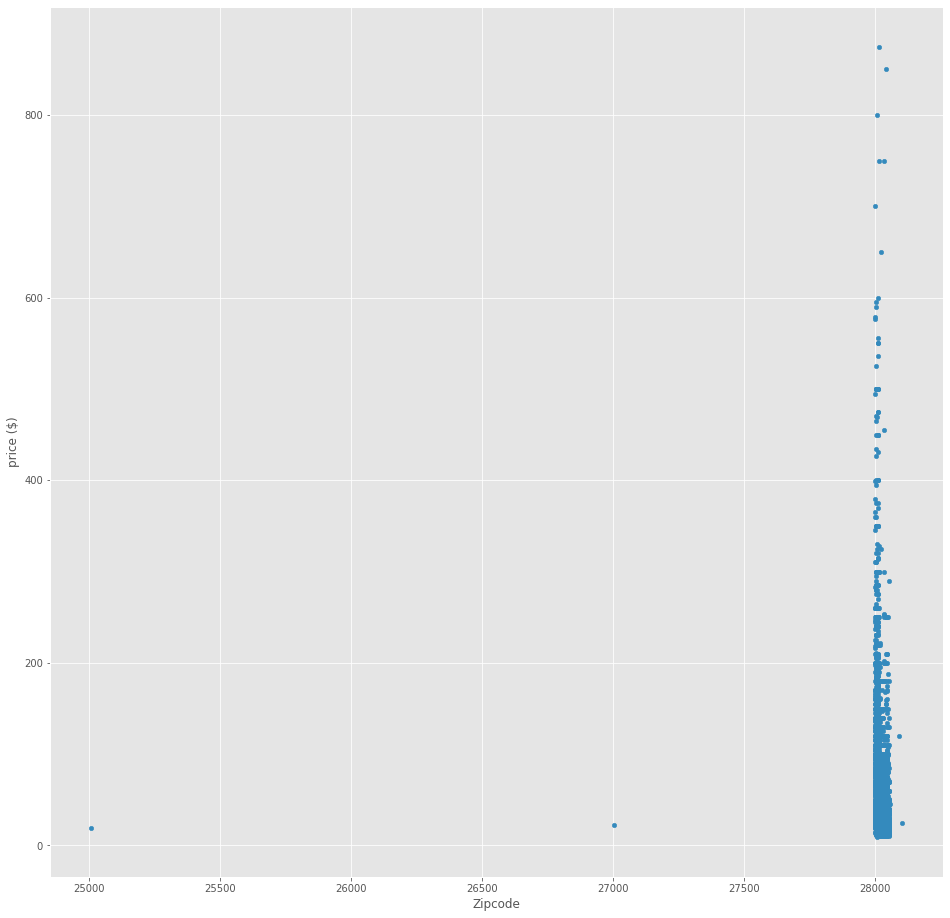

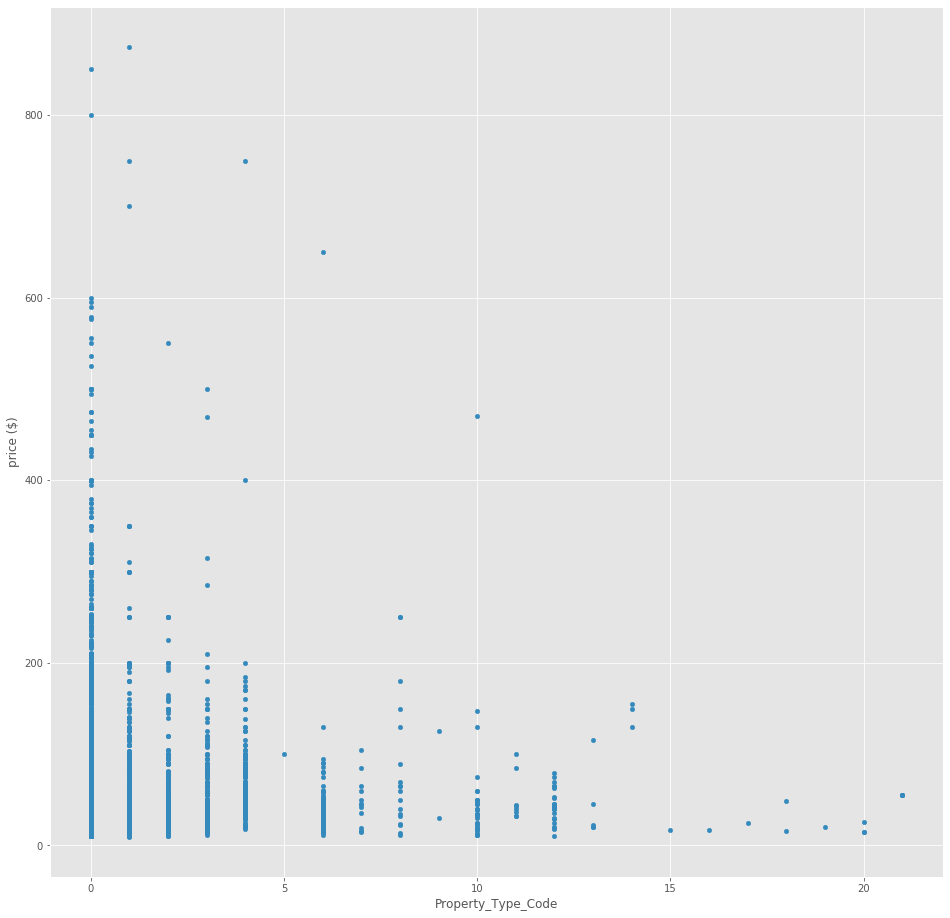

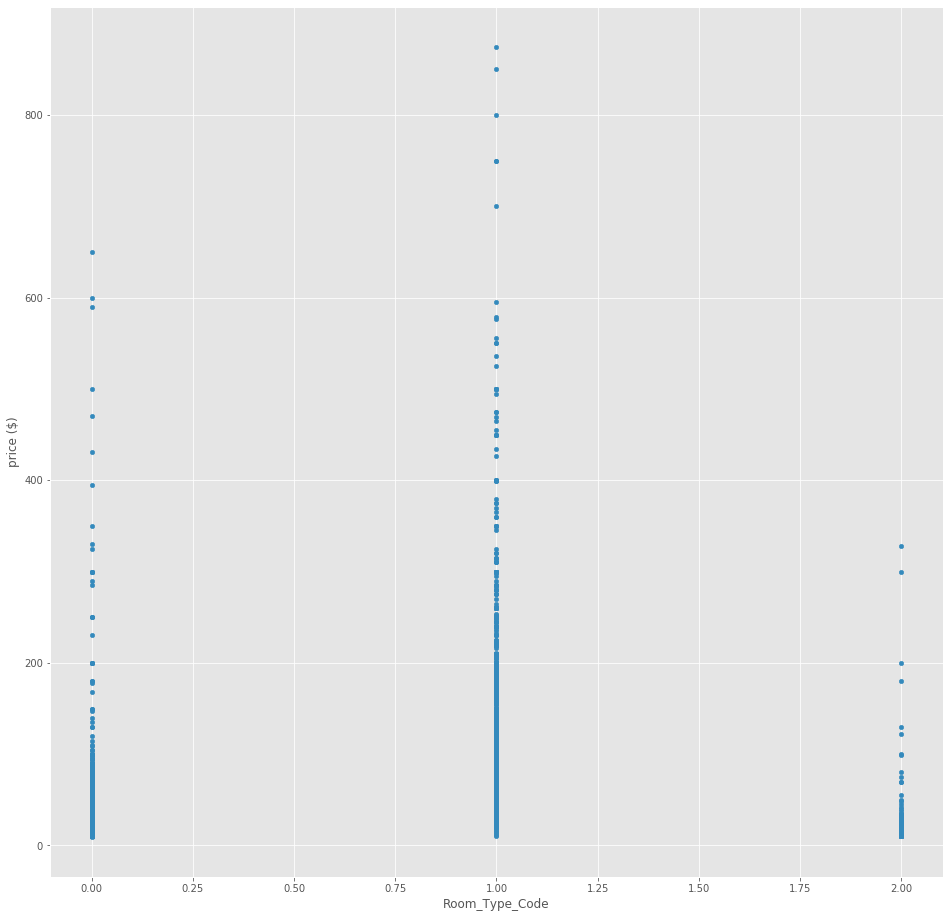

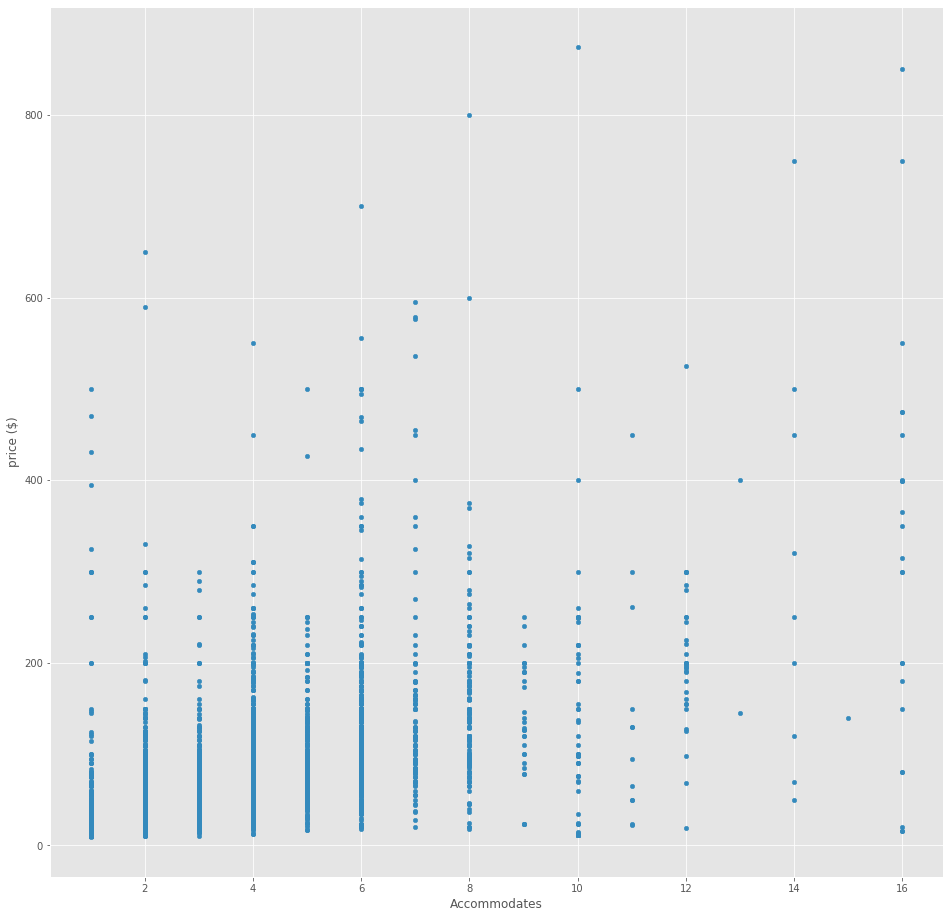

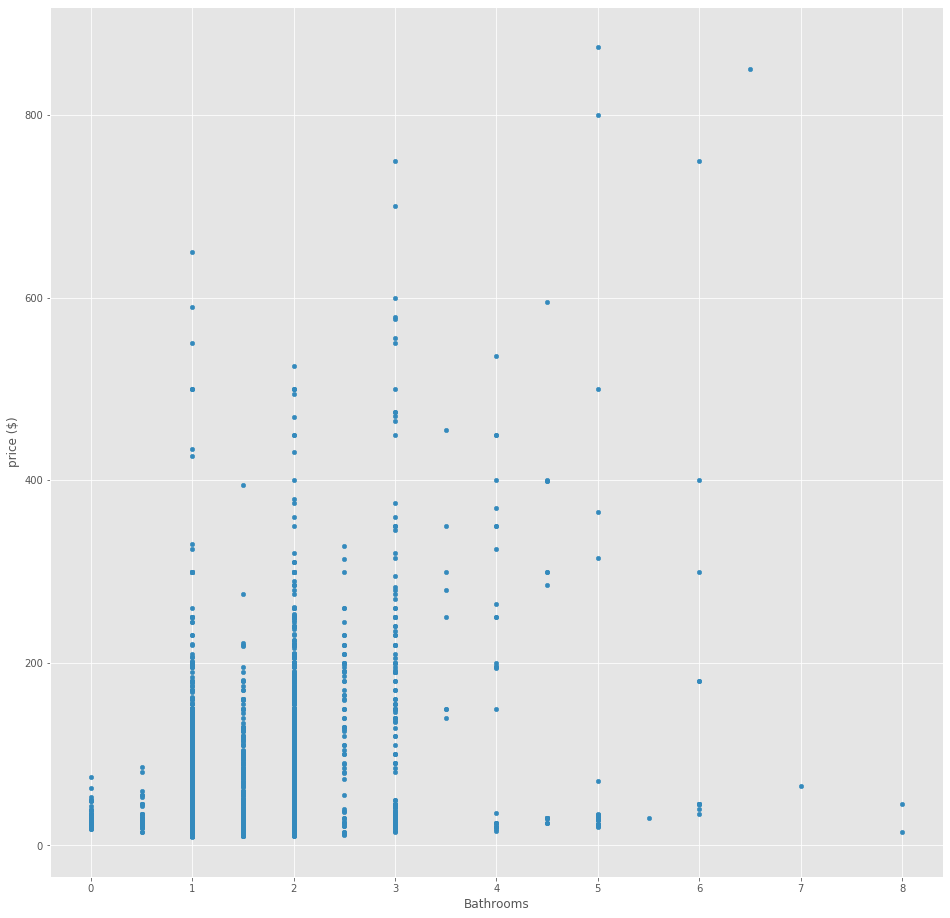

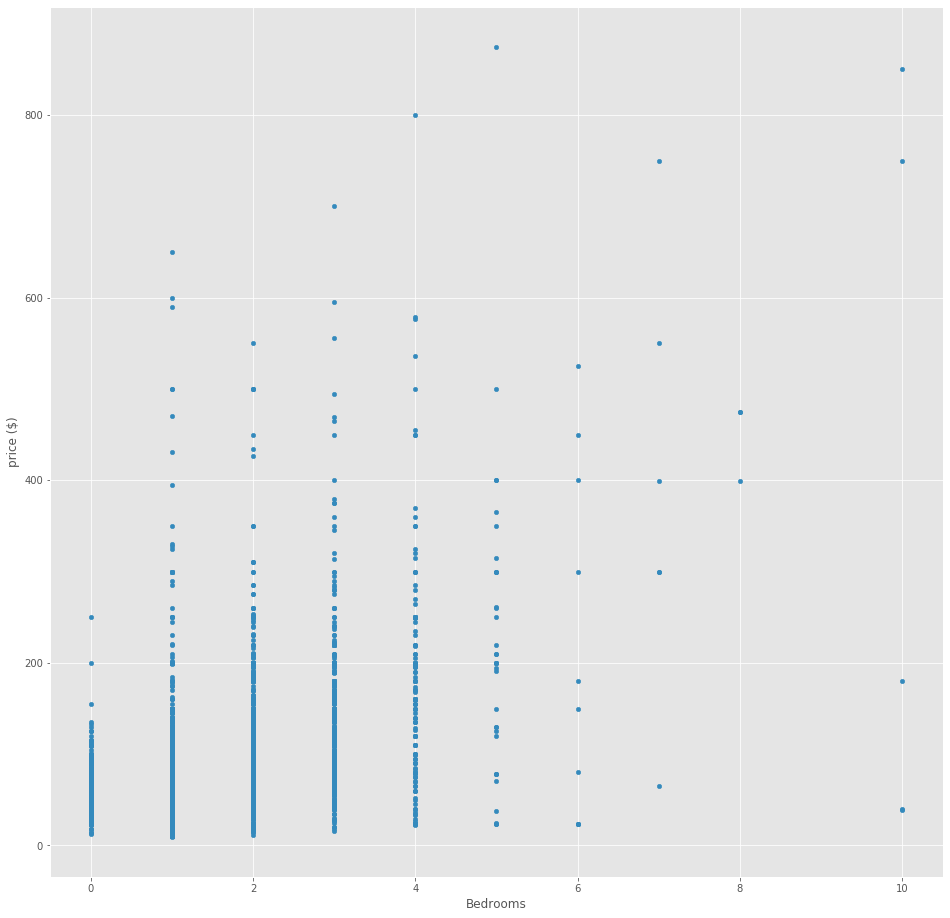

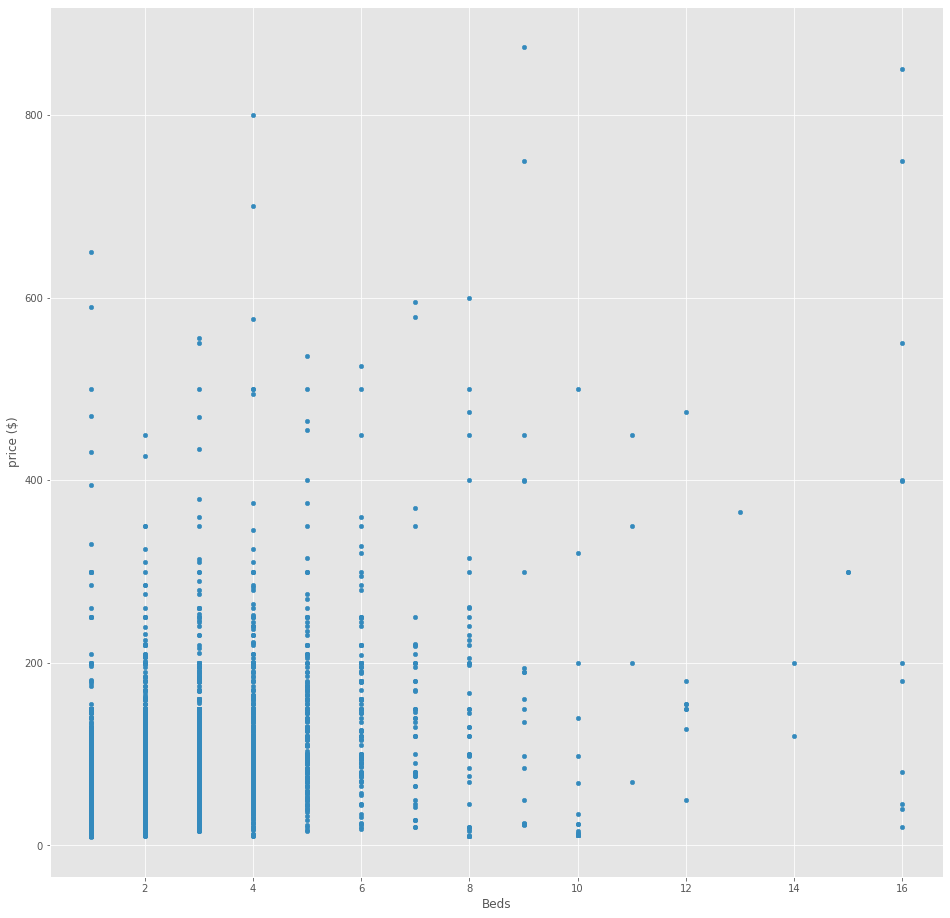

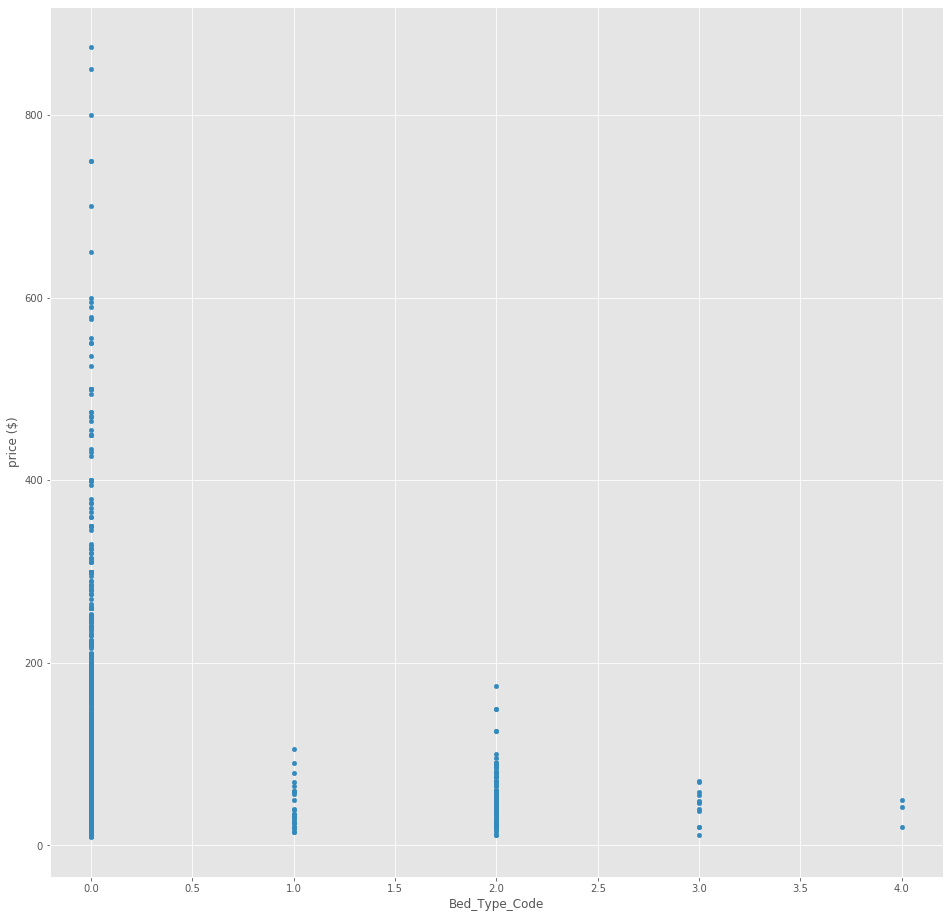

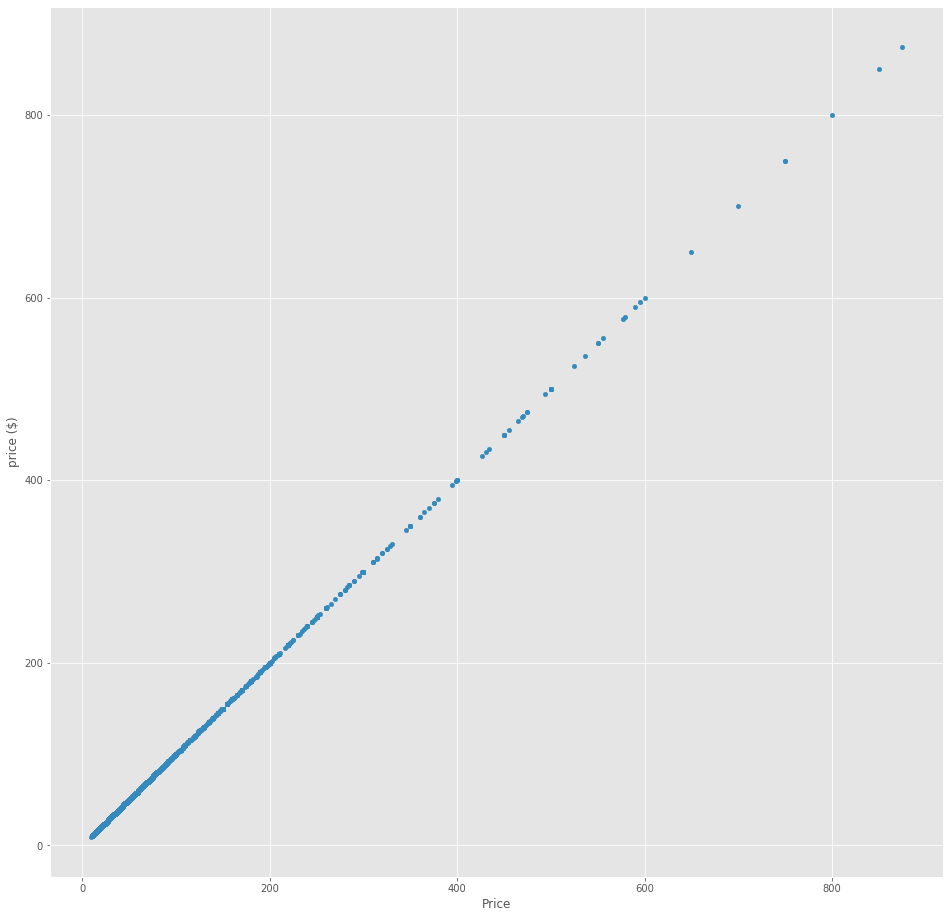

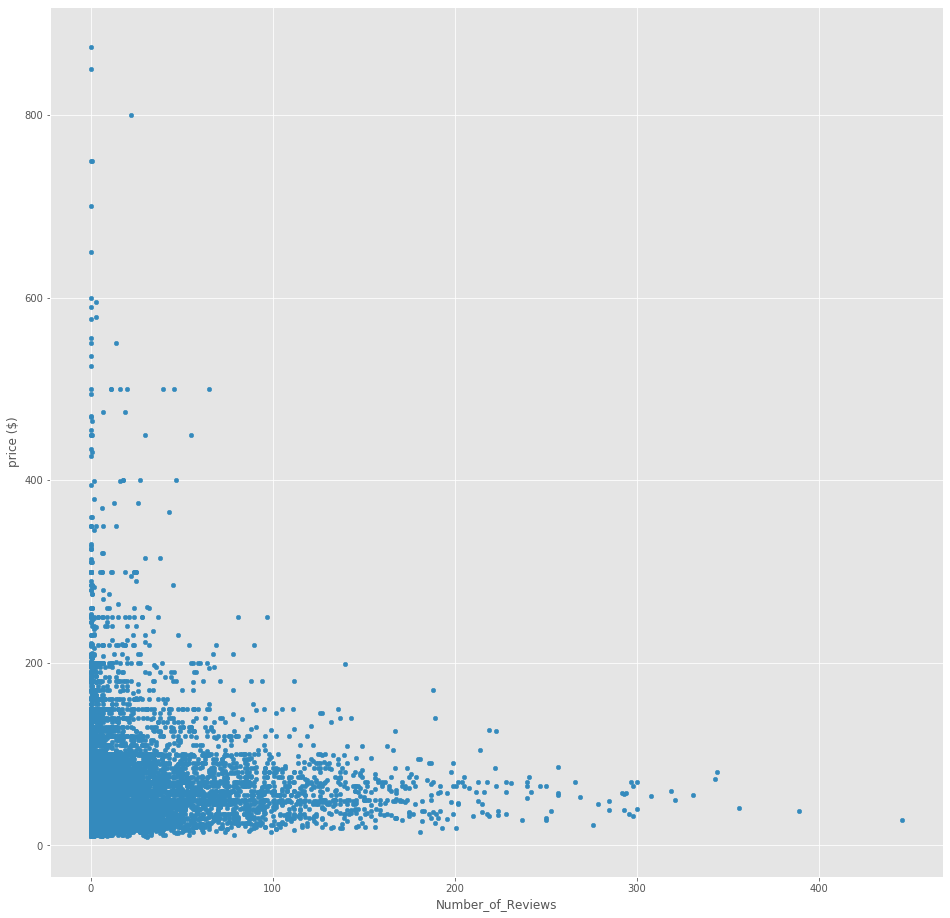

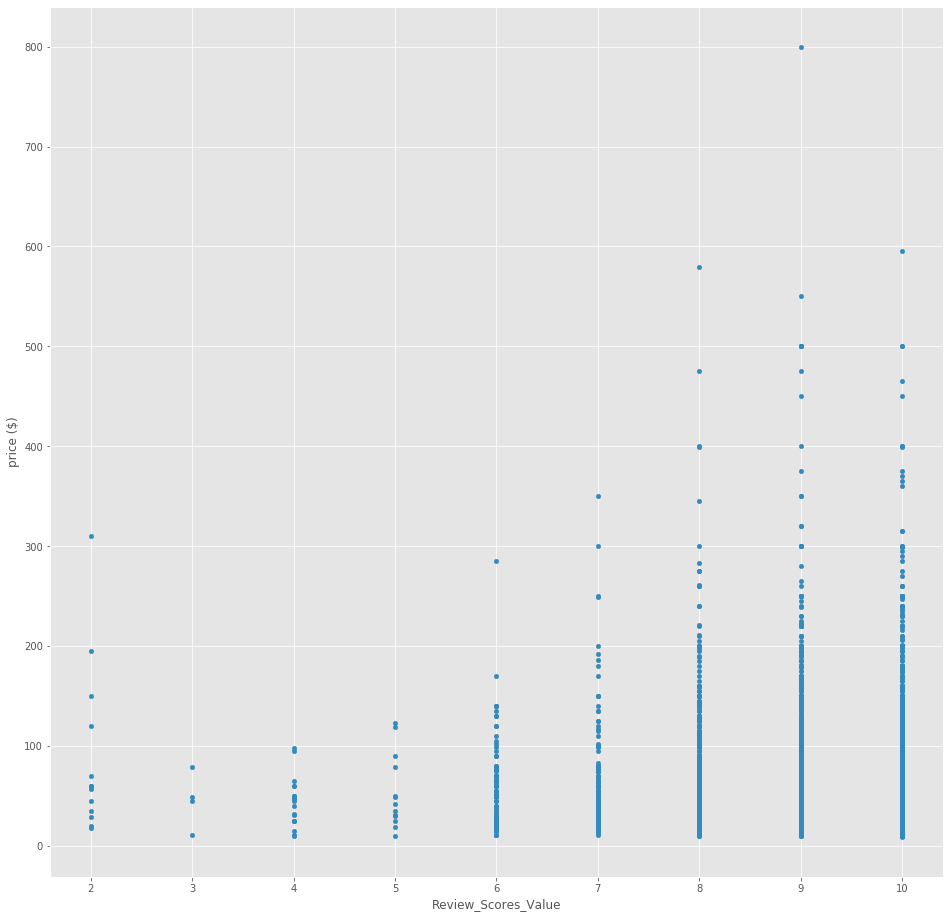

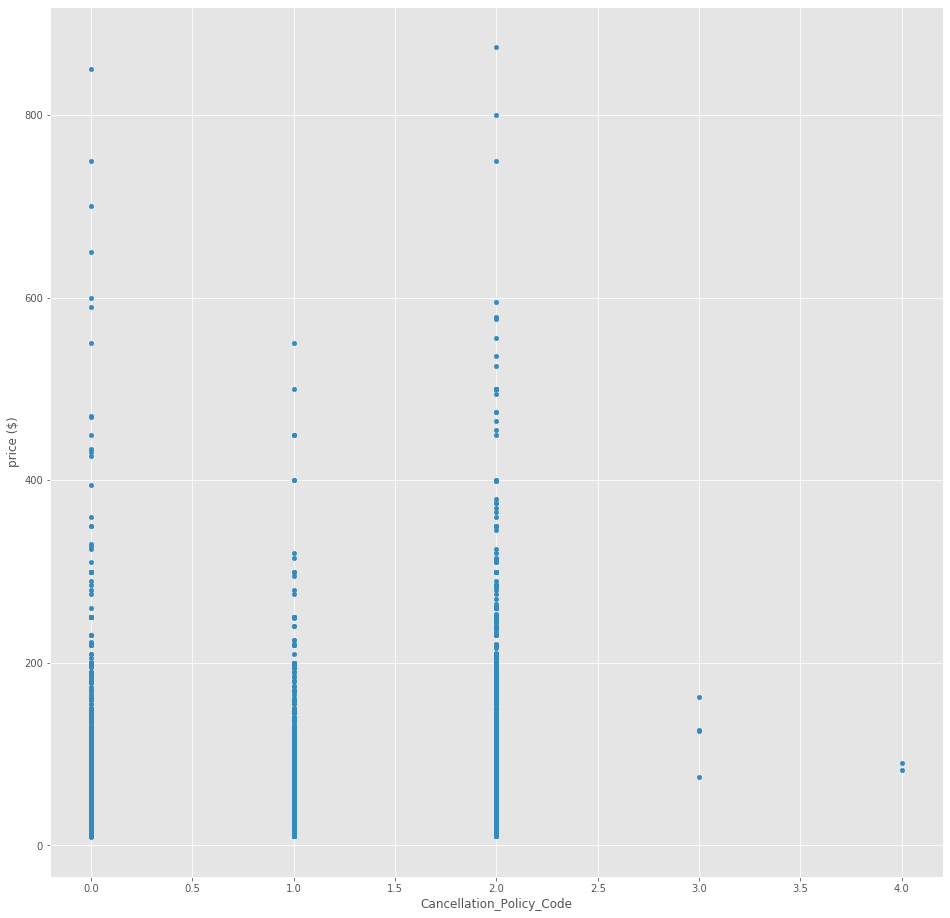

In [26]:
# Chequeo de nuevo los outliers tras los cambios realizados:

df_filter = df_train

df_filter = delete_object_columns(df_filter)

for column in df_filter.columns:
    df_filter.plot(kind = 'scatter',x=f'{column}',y = 'Price')
    plt.xlabel(column)
    plt.ylabel('price ($)')
    plt.show()

In [27]:
df_train = df_train[df_train["Price"] <= 325]
df_train = df_train[df_train["Bathrooms"] <= 6]
df_train = df_train[df_train["Bedrooms"] <= 8]
df_train = df_train[df_train["Zipcode"] >= 28001] # Este valor lo he sacado mirando los códigos postales de madrid
df_train = df_train[df_train["Zipcode"] < 28523] # Este valor lo he sacado mirando los códigos postales de madrid

Separo el dataset en dos para tener un dataset de train y otro de test.

### Limpieza del dataframe de train para crear el modelo predictivo.

In [28]:
df_train.isnull().sum(axis = 0)

Neighbourhood               2997
Zipcode                        0
Property_Type                  0
Property_Type_Code             0
Room_Type                      0
Room_Type_Code                 0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           5
Bed_Type                       0
Bed_Type_Code                  0
Price                          0
Number_of_Reviews              0
Review_Scores_Value         1997
Cancellation_Policy            0
Cancellation_Policy_Code       0
dtype: int64

In [29]:
# Los valores nulos que contiene el campo "review_scores_value" los voy a sustuir con la media:
reviews_score_mean = df_train["Review_Scores_Value"].mean()
df_train['Review_Scores_Value'] = df_train['Review_Scores_Value'].fillna(reviews_score_mean)

In [30]:
df_train.isnull().sum(axis = 0)

Neighbourhood               2997
Zipcode                        0
Property_Type                  0
Property_Type_Code             0
Room_Type                      0
Room_Type_Code                 0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           5
Bed_Type                       0
Bed_Type_Code                  0
Price                          0
Number_of_Reviews              0
Review_Scores_Value            0
Cancellation_Policy            0
Cancellation_Policy_Code       0
dtype: int64

In [31]:
# Me quedo únicamente con los campos numéricos y los campos codificados y los convierto a int64.

df_train = delete_object_columns(df_train)
df_train = convert_to_numeric(df_train)

In [32]:
# Elimino los valores nulos del dataframe de train:

# De esta forma puedo incluirlo en la matriz de correlación.

for column in df_train.columns:
    df_train= df_train[df_train[column].notna()]

#### Matriz de correlación creada a partir del dataframe de train.

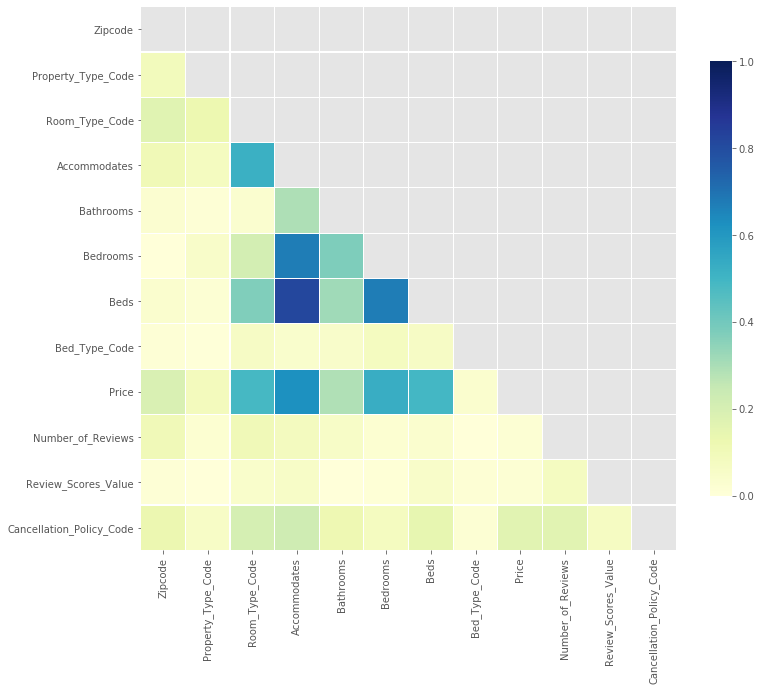

In [33]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Por lo que vemos en la matriz de correlación, el precio de una vivienda depende principalmente del número de personas, el número de baños, el número de habitaciones,el número de camas de la vivienda y el tipo de habitación.

En menor medida, parece que también depende del código postal.

Viendo la matriz de correlación, parece que que podemos eliminar las columnas de **Bed_Type**, **Property_type_code**, **Zipcode** para crear el modelo predictivo para calcular el precio.

In [34]:
df_train.corr() # matriz de correlación

,Zipcode,Property_Type_Code,Room_Type_Code,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type_Code,Price,Number_of_Reviews,Review_Scores_Value,Cancellation_Policy_Code
Zipcode,1.000000,0.090894,-0.171238,-0.107540,-0.030629,-0.000127,-0.037443,-0.012568,-0.194096,-0.104946,0.013503,-0.131712
Property_Type_Code,0.090894,1.000000,-0.128284,-0.080853,0.012250,-0.052014,-0.022836,-0.003959,-0.087662,-0.025487,-0.001123,-0.059061
Room_Type_Code,-0.171238,-0.128284,1.000000,0.521713,-0.034859,0.214762,0.373325,0.063446,0.491999,0.104639,-0.045744,0.205446
Accommodates,-0.107540,-0.080853,0.521713,1.000000,0.294150,0.674265,0.819692,-0.040277,0.623980,0.083963,-0.058479,0.223036
Bathrooms,-0.030629,0.012250,-0.034859,0.294150,1.000000,0.377988,0.317117,-0.047782,0.291127,-0.054969,-0.001529,0.119587
Bedrooms,-0.000127,-0.052014,0.214762,0.674265,0.377988,1.000000,0.673422,-0.081949,0.531113,-0.026395,-0.008795,0.079142
Beds,-0.037443,-0.022836,0.373325,0.819692,0.317117,0.673422,1.000000,-0.063076,0.495618,0.036199,-0.053625,0.148000
Bed_Type_Code,-0.012568,-0.003959,0.063446,-0.040277,-0.047782,-0.081949,-0.063076,1.000000,-0.038650,0.000788,0.017380,0.021276
Price,-0.194096,-0.087662,0.491999,0.623980,0.291127,0.531113,0.495618,-0.038650,1.000000,-0.022207,0.020553,0.166786
Number_of_Reviews,-0.104946,-0.025487,0.104639,0.083963,-0.054969,-0.026395,0.036199,0.000788,-0.022207,1.000000,0.075683,0.165631


### Elimino las columnas que parecen menos relevantes según la matriz de correlación

In [35]:
df_train = df_train.drop(columns=["Bed_Type_Code","Property_Type_Code","Number_of_Reviews","Review_Scores_Value","Zipcode"])

### Histograma del dataframe de entrenamiento

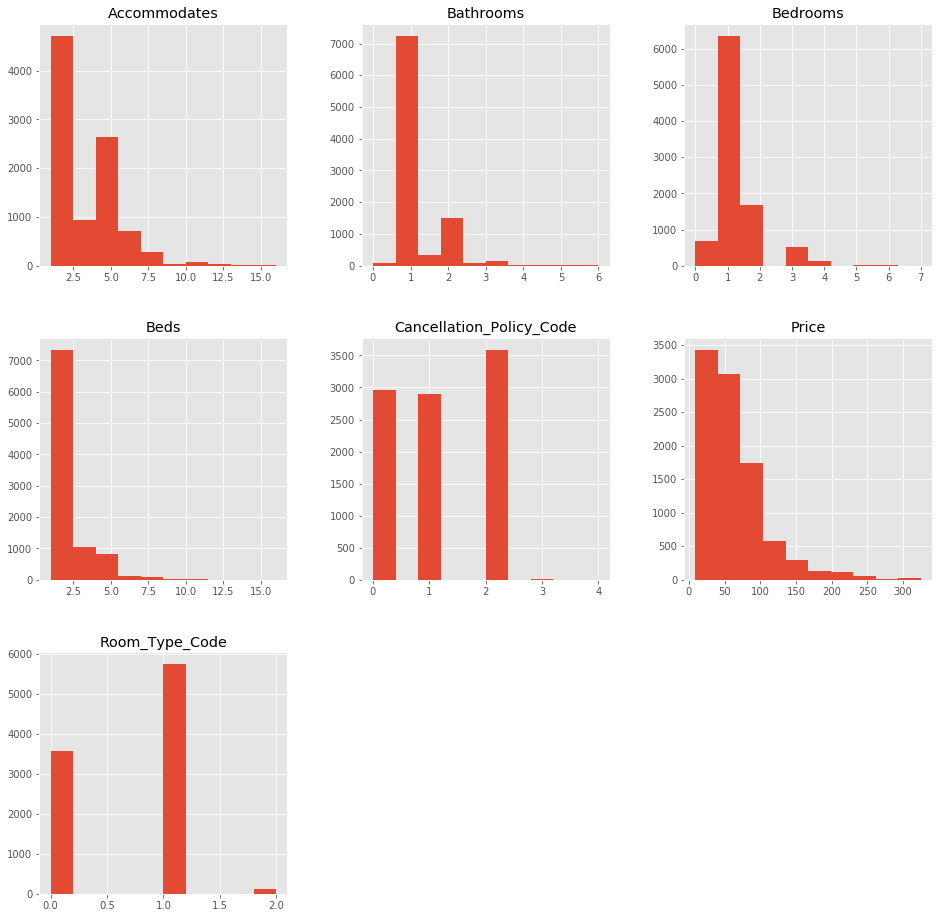

In [36]:
df_train.hist()
plt.show()

### Vamos a comentar las gráficas anteiores:

* Vemos que la mayoría de viviendas aceptan entre 1 y 5 personas.

* La mayoría de viviendas cuentan con un baño y unas pocas con 2 baños.

* Vemos que la mayoría de viviendas tiene entre 1 y 3 habitaciones. La mayoría cuenta solo con una.

* Respecto al número de camas, vemos que la mayoría de casas tiene solo 1 cama, pero también hay agunas viviendas que             cuentan hasta con 5 camas.

* Respecto a la política de cancelación, vemos que está muy repartido entre {'moderate':0,'flexible': 1,'strict':2}.

* Respecto al precio, vemos que la mayoría de viviendas oslizan entre 0 y 200€.

* Respecto a Property Type Code, vemos que la mayoría son {'Apartment': 0}.

* Respecto a los Room Type, vemos que la inmensa mayoría de viviendas que se ofertan son de tipo "Entire home/apt".
  {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}

In [37]:
# La función order columns recibe como parámetro el dataframe con el que estamos trabajando y ordena las columnas para 
# poder crear de una forma más sencilla el modelo. En este caso colocamos la columna "Price" en primer lugar.
def order_columns(dataframe):
    
    columns = []

    for column in dataframe.columns:
        if column == "Price":
            columns.insert(0, column)

        else:
            columns.append(column)    
            
    dataframe = dataframe[columns]
    
    return dataframe
    

In [38]:
# Implementamos la función "order_columns" tanto en el dataset de train como en el de test:
df_train = order_columns(df_train)

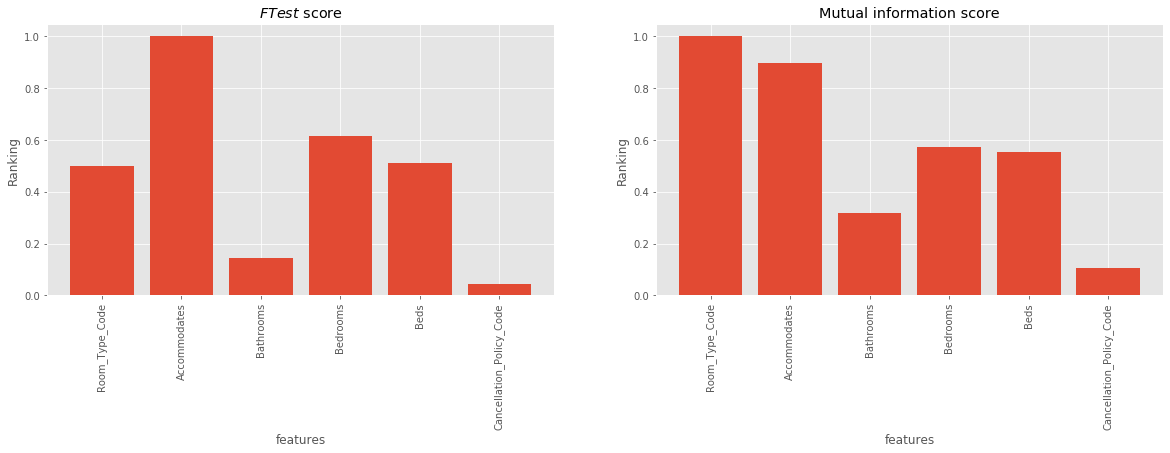

In [39]:
# convertimos el DataFrame al formato necesario para scikit-learn
# Pongo la columna "Price en primer lugar"

data = df_train.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df_train.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

### Modificación del dataframe de test

Una vez tengo el dataframe de train procesado y con todos los cambios necearios para crear correctamente el modelo.
Aplico los mismos cambios al dataframe de test.

Para ello, utilizo secuencialmente todos los métodos implementados:

In [40]:
def main_process_data_test(dataframe):
    
    df_processed = select_columns(dataframe) # Selección de columnas inicial
    
    df_processed = clean_zipcode(df_processed) # Limpieza y procesamiento del campo ZipCode
    
    df_processed = column_encode(df_processed,"Neighbourhood") # Codificación 
    df_processed = column_encode(df_processed,"Property_Type") # Codificación 
    df_processed = column_encode(df_processed,"Room_Type") # Codificación 
    df_processed = column_encode(df_processed,"Bed_Type") # Codificación 
    df_processed = column_encode(df_processed,"Cancellation_Policy") # Codificación 
    
    df_processed = drop_columns_nulls(df_processed) # Eliminación de las columnas que tienen altos porcentajes de valores nulos
    
    # Elimino outliers
    df_processed = df_processed[df_processed["Price"] <= 325]
    df_processed = df_processed[df_processed["Bathrooms"] <= 6]
    df_processed = df_processed[df_processed["Bedrooms"] <= 8]
    df_processed = df_processed[df_processed["Zipcode"] >= 28001] # Este valor lo he sacado mirando los códigos postales de madrid
    df_processed = df_processed[df_processed["Zipcode"] < 28523] # Este valor lo he sacado mirando los códigos postales de madrid
    
    # Los valores nulos que contiene el campo "review_scores_value" los voy a sustuir con la media:
    reviews_score_mean = df_processed["Review_Scores_Value"].mean()
    df_processed['Review_Scores_Value'] = df_processed['Review_Scores_Value'].fillna(reviews_score_mean)
    
    df_processed = delete_object_columns(df_processed) # Eliminación de columnas de tipo 'object'
    df_processed = convert_to_numeric(df_processed) # Convertir todo a numerico
    
    
    
    for column in df_processed.columns:
        df_processed= df_processed[df_processed[column].notna()] # Eliminación de los valores nulos dentro del dataframe
        
    
    # Eliminación de las columnas menos relevantes tras crear la matriz de correlación
    df_processed = df_processed.drop(columns=["Bed_Type_Code","Property_Type_Code","Number_of_Reviews","Review_Scores_Value","Zipcode"]) 
    
    #Ordenar las columnas para crear el modelo
    df_processed = order_columns(df_processed)
        
    return df_processed

In [41]:
df_test = main_process_data_test(df_test)

### La función check_dataframes

Sirve para asegurarnos que el dataframe de test no contiene nada que no sea reconocible por el modelo creado con el dataframe
de train

In [42]:
# La función check_dataframes, recibe como parámetros el dataframe de train y el de test.
# El objetivo de está función, es que no haya ningún dato en el dataframe de test que sea desconocido para el modelo predictivo
# que hemos creado con el dataframe de train.

def check_dataframes(df_train, df_test):
    
    df_train_columns = list(df_train.columns)
    
    df_test_columns = list(df_test.columns)
    
    for column in df_test_columns:
        if column not in df_train_columns:
            df_test = df_test.drop(columns = [f"{column}"])
    
    for column in df_train_columns:
        
        unique_values_train = [value for value in list(df_train[column].unique())]
        
        unique_values_test = [value for value in list(df_test[column].unique())]
        
        delete_values = [value for value in unique_values_test if value not in unique_values_train]
        
        for value in delete_values:
            df_test = df_test[df_test[column] != value] # Mantenemos en df_test solo los valores que conoce nuestro modelo.
        
    return df_train, df_test

In [43]:
df_train, df_test = check_dataframes(df_train,df_test)

In [44]:
# Vemos que apenas hemos perdido información tras la limpieza del dataset.

print(df_train.shape)
print(df_test.shape)

(9457, 7)
(3123, 7)


In [45]:
print(df_test.columns)
print(df_train.columns)

Index(['Price', 'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Cancellation_Policy_Code'],
      dtype='object')
Index(['Price', 'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Cancellation_Policy_Code'],
      dtype='object')


In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [47]:
# Creamos numpy_arrays a partir del dataframe de train
data_train = df_train.values
y_train = data_train[:,0]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [48]:
# Creamos numpy_arrays a partir del dataframe de test
data_test = df_test.values
y_test = data_test[:,0]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

## Modelo SVM

In [49]:
from sklearn import preprocessing

# paso 1
y_train = np.log10(y_train)
y_test = np.log10(y_test)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled  = scaler.transform(X_test)

Datos entrenamiento:  (9457, 6)
Datos test:  (3123, 6)


In [ ]:
# Paso 2:
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()

#### El resultado sale mal. He revisado el proceso, y no he encontrado nada fuera de lugar. He seguido los pasos
#### pero no sale un resultado coeherente.

In [ ]:
# Paso 3:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))